#**LABORATORIO 1 - MLP PYTORCH**

Nombre: Quispe Sucullani Jose David

Enlace de GitHub:

##*LABORATORIO 1*

###Construir un MLP, con pytorch, considerando lo siguiente:

- El MLP, debe servir para realizar clasificaciones de al menos 5 clases o tipos de difentes ambitos.

- El MLP debe contener al menos 50 unidades  neuronales en una capa oculta.

- Se debe entrenar por almenos 1000 epochs y explicar que sucede en este proceso.

- Se debe implementar un mecanismo de checkpoints para el proceso de entrenamiento que permita respaldar los valores calculados para los parametros, cada 20 epochs.

- Aplicar las formas (frameworks) de exportación de modelos Torchscript y ONNX, a traves de ejemplos.

- Utilizar de manera obligatoria objetos dataset y dataloader en la implementacion.

- Se debe aplicar las tecnicas de normalizacion, optimizacion y buenas practicas para lograr el menor valor de costo y el mayor valor de precision.


Se debe subir todo a un repositorio el cual debes ser compartido, ademas de subir todos los cuadernillos o codigo fuente generados.

In [1]:
# IMPORTAMOS LAS LIBRERIAS

import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm  # Importar tqdm para la barra de progreso
from torch.cuda.amp import autocast, GradScaler  # Para mixed precision training

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1: Lectura del Dataset**

Transformaciones: Redimensionamos los imagenes a 128x128 píxeles para convierten en tensores. La normalización se realiza para que los valores de píxeles estén en un rango adecuado para el entrenamiento del modelo.

In [3]:
# Definir las transformaciones para las imágenes
from torchvision import datasets, transforms
import torch.utils.data

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Cargar el conjunto de datos de entrenamiento y prueba con las transformaciones
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 4015
Número de imágenes de prueba: 4009


In [4]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Función para limitar el número de archivos de cada subcarpeta
def limit_dataset_size(root_dir, max_per_class=6000):
    # Diccionario para almacenar rutas de las imágenes seleccionadas por clase
    limited_dataset = []

    # Iteramos por las subcarpetas en root_dir (cada subcarpeta es una clase)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Obtenemos todas las imágenes en la subcarpeta
            all_images = os.listdir(class_dir)
            # Filtramos para obtener solo imágenes, excluyendo otros tipos de archivos
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Seleccionamos aleatoriamente 6000 imágenes
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset



In [5]:
# Definir la ruta del dataset
root_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train'

# Obtener una lista de las rutas de imágenes limitadas a 6000 por clase
limited_image_paths = limit_dataset_size(root_dir, max_per_class=6000)

# Clase personalizada para cargar solo las imágenes seleccionadas
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, selected_files, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # Filtrar el dataset para cargar solo las imágenes seleccionadas
        self.samples = [(os.path.join(root, img), self.class_to_idx[img.split('/')[0]]) for img in selected_files]
        self.targets = [s[1] for s in self.samples]  # Extraer las etiquetas

# Crear el dataset personalizado usando solo las imágenes seleccionadas
train_data = CustomImageFolder(root=root_dir, selected_files=limited_image_paths, transform=transform)

# Verificar el número de imágenes en el nuevo conjunto de entrenamiento
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verificar el número de imágenes por clase
from collections import Counter
print("Distribución de imágenes por clase:", Counter(train_data.targets))

Número total de imágenes en el nuevo conjunto de entrenamiento: 4015
Distribución de imágenes por clase: Counter({2: 810, 0: 805, 4: 800, 1: 800, 3: 800})


In [6]:
# 1. Ver las etiquetas del dataset (clases):
# Ver las clases del dataset (etiquetas)
print(f"Clases en el conjunto de entrenamiento: {train_data.classes}")
print(f"Cantidad de clases: {len(train_data.classes)}")

Clases en el conjunto de entrenamiento: ['Anillo-De-Lata', 'Bolsas-Soda', 'Cable-De-Red', 'Hojas-Brocoli', 'Monedas']
Cantidad de clases: 5


In [7]:
import torch
from collections import Counter

# Verificar el número total de imágenes en el conjunto de entrenamiento
num_total_images = len(train_data)
print(f"Número total de imágenes en el conjunto de entrenamiento: {num_total_images}")

# Verificar el número de clases (etiquetas)
num_classes = len(train_data.classes)
print(f"Número de clases: {num_classes}")

# Obtener las etiquetas de todas las imágenes (train_data.targets tiene las etiquetas de cada imagen)
class_distribution = Counter(train_data.targets)

# Mostrar cuántas imágenes hay por clase
for class_idx, count in class_distribution.items():
    print(f"Clase '{train_data.classes[class_idx]}' tiene {count} imágenes")


Número total de imágenes en el conjunto de entrenamiento: 4015
Número de clases: 5
Clase 'Monedas' tiene 800 imágenes
Clase 'Cable-De-Red' tiene 810 imágenes
Clase 'Anillo-De-Lata' tiene 805 imágenes
Clase 'Bolsas-Soda' tiene 800 imágenes
Clase 'Hojas-Brocoli' tiene 800 imágenes


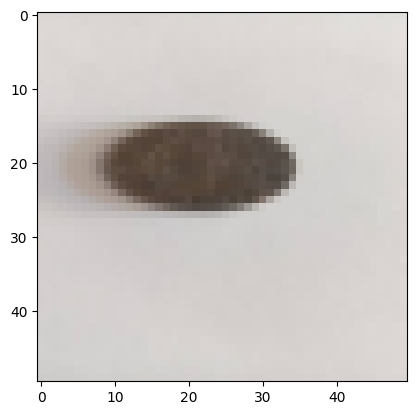

Etiquetas: Monedas


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Función para mostrar imágenes
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar la imagen
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostrar algunas imágenes del conjunto de entrenamiento
dataiter = iter(train_data)
images, labels = next(dataiter)

# Mostrar las imágenes
imshow(torchvision.utils.make_grid(images))

# Mostrar las etiquetas correspondientes
# Check if labels is an integer and convert it to a list if necessary
if isinstance(labels, int):
    labels = [labels]

print('Etiquetas:', ' '.join(f'{train_data.classes[labels[j]]}' for j in range(len(labels))))

In [9]:
# Preparar los DataLoaders en formato de diccionario
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 4015
Número de imágenes de prueba: 4009


In [10]:
# Obtener un lote de imágenes y etiquetas del DataLoader de entrenamiento
images, labels = next(iter(dataloader['train']))

# Mostrar el tamaño del lote de imágenes y etiquetas
print(f"Tamaño del lote de imágenes: {images.shape}")  # Dimensiones del tensor de imágenes
print(f"Tamaño del lote de etiquetas: {labels.shape}")  # Dimensiones del tensor de etiquetas

# Ver la primera etiqueta en el lote y su correspondencia con la clase
print(f"Primera etiqueta en el lote: {labels[0].item()}")  # Mostrar el valor de la primera etiqueta
print(f"Clase correspondiente: {train_data.classes[labels[0]]}")  # Mostrar la clase asociada

Tamaño del lote de imágenes: torch.Size([64, 3, 50, 50])
Tamaño del lote de etiquetas: torch.Size([64])
Primera etiqueta en el lote: 2
Clase correspondiente: Cable-De-Red


Aplicamos la utilización de los objetos de dataset y DataLoader para poder facilitar los dataset de grandes magnitudes dividiendo en lotes de batch_size

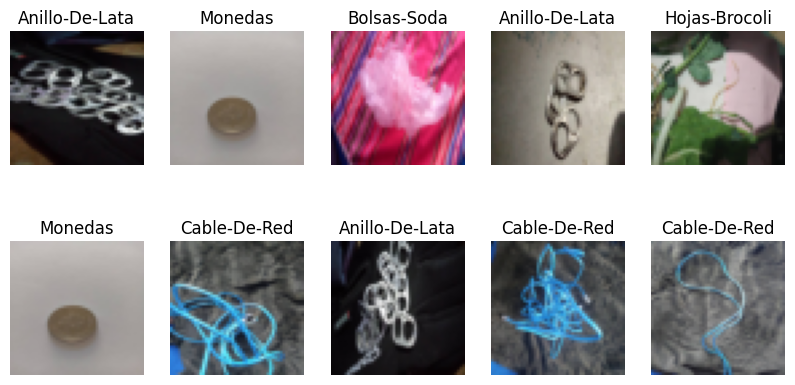

In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

#**2: Construcción del Modelo MLP**

Ahora realizaremos la arquitectura del MLP, asegurando que cumpla con las especificaciones: al menos 50 unidades neuronales en una capa oculta y una capa de salida con 5 unidades, una para cada clase de clase.

In [12]:

import torch.nn as nn
import torch.nn.functional as F

# Definir un bloque secuencial de capas fully connected con activación y dropout
def fc_block(input_size, output_size, dropout_rate=0.5):
    return nn.Sequential(
        nn.Linear(input_size, output_size),  # Capa totalmente conectada (fully connected)
        nn.ReLU(),                           # Activación ReLU
        nn.Dropout(dropout_rate)             # Dropout para regularización
    )

class MLP(nn.Module):
    def __init__(self, input_size=50*50*3, n_classes=5):
        super(MLP, self).__init__()
        # Definir las capas fully connected utilizando bloques
        self.fc1 = fc_block(input_size, 50, dropout_rate=0.5)  # Capa de entrada con 7500 unidades y 50 neuronas
        self.fc2 = fc_block(50, 30, dropout_rate=0.5)         # Capa oculta con 30 unidades de neuronas
        self.fc3 = nn.Linear(30, n_classes)                    # Capa de salida con 5 clases (una por cada clase)

    def forward(self, x):
        x = x.view(-1, 50 * 50 * 3)  # Aplanar las imágenes
        x = self.fc1(x)              # Pasar a través del primer bloque fully connected
        x = self.fc2(x)              # Pasar a través del segundo bloque fully connected
        x = self.fc3(x)              # Pasar a través de la capa de salida
        return x


In [13]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#**3: Configuración del Entrenamiento**

Entrenaremos el modelo durante 100 epochs, implementando un mecanismo de checkpoints para guardar el modelo cada 20 epochs. Además, aplicaremos técnicas de optimización y buenas prácticas.

In [ ]:
!pip install tqdm

In [27]:
import torch
import numpy as np
from tqdm import tqdm

# Ruta donde se guardarán los checkpoints
checkpoint_dir = "/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1/"

# Función para guardar un checkpoint en la ruta especificada
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    # Construct the full path correctly
    full_path = os.path.join(checkpoint_dir, filename)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, full_path)
    print(f'Checkpoint guardado en: {full_path}')



# Función para cargar un checkpoint desde la ruta especificada
def load_checkpoint(filename, model, optimizer):
    # Construct the full path correctly
    full_path = os.path.join(checkpoint_dir, filename)
    checkpoint = torch.load(full_path, weights_only=False)  # Add weights_only=False
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Checkpoint cargado desde epoch {epoch} con pérdida {loss:.4f}')
    return epoch, loss

Entrenamiento desde cero y guardado de checkpoints:

In [15]:
# Función para entrenar el modelo y guardar checkpoints automáticamente
def fit_train(model, dataloader, epochs=10, lr=1e-3, checkpoint_interval=5):
    model.to(device)  # Mover el modelo al dispositivo (CPU o GPU)

    # Optimizador Adam y función de pérdida CrossEntropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Inicializar listas para pérdidas y precisiones del entrenamiento
        model.train()
        train_loss, train_acc = [], []

        # Barras de progreso para los datos de entrenamiento
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} - Training")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward pass (propagación hacia adelante)
            y_hat = model(X)

            # Cálculo de la pérdida
            loss = criterion(y_hat, y)

            # Backward pass (retropropagación) y actualización del optimizador
            loss.backward()
            optimizer.step()

            # Guardar el valor de la pérdida
            train_loss.append(loss.item())

            # Cálculo de precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Actualización de la barra de progreso
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Validación del modelo después de cada época
        model.eval()  # Cambiar a modo de evaluación
        val_loss, val_acc = [], []

        with torch.no_grad():  # Desactivar el cálculo del gradiente
            bar = tqdm(dataloader['test'], desc=f"Epoch {epoch}/{epochs} - Validation")

            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                # Forward pass en modo evaluación
                y_hat = model(X)

                # Cálculo de la pérdida de validación
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())

                # Cálculo de la precisión de validación
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                # Actualización de la barra de progreso
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Mostrar métricas al final de la época
        print(f"Epoch {epoch}/{epochs} - Train loss: {np.mean(train_loss):.5f} - Validation loss: {np.mean(val_loss):.5f} - Train acc: {np.mean(train_acc):.5f} - Validation acc: {np.mean(val_acc):.5f}")

        # Guardar checkpoint cada cierto número de epochs
        if epoch % checkpoint_interval == 0:
            save_checkpoint(epoch, model, optimizer, np.mean(train_loss), filename=f'MLP_checkpoint_epoch_{epoch}.pth')


In [16]:
# Crear instancia del modelo MLP y entrenar desde cero
model = MLP()
fit_train(model, dataloader, epochs=10, lr=1e-3, checkpoint_interval=2)

val_loss 1.34308 val_acc 0.72024: 100%|██████████| 63/63 [57:17<00:00, 54.57s/it]


Epoch 1/10 - Train loss: 0.68059 - Validation loss: 1.34308 - Train acc: 0.74881 - Validation acc: 0.72024


val_loss 1.67422 val_acc 0.73636: 100%|██████████| 63/63 [00:27<00:00,  2.31it/s]


Epoch 2/10 - Train loss: 0.24810 - Validation loss: 1.67422 - Train acc: 0.91448 - Validation acc: 0.73636
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_2.pth


val_loss 2.15285 val_acc 0.74578: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 3/10 - Train loss: 0.15538 - Validation loss: 2.15285 - Train acc: 0.94956 - Validation acc: 0.74578


val_loss 2.52048 val_acc 0.74727: 100%|██████████| 63/63 [00:27<00:00,  2.32it/s]


Epoch 4/10 - Train loss: 0.11633 - Validation loss: 2.52048 - Train acc: 0.96361 - Validation acc: 0.74727
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_4.pth


val_loss 2.60273 val_acc 0.75223: 100%|██████████| 63/63 [00:27<00:00,  2.32it/s]


Epoch 5/10 - Train loss: 0.09538 - Validation loss: 2.60273 - Train acc: 0.97047 - Validation acc: 0.75223


val_loss 2.73605 val_acc 0.74727: 100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


Epoch 6/10 - Train loss: 0.08436 - Validation loss: 2.73605 - Train acc: 0.97396 - Validation acc: 0.74727
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_6.pth


val_loss 2.98050 val_acc 0.75000: 100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


Epoch 7/10 - Train loss: 0.08385 - Validation loss: 2.98050 - Train acc: 0.97288 - Validation acc: 0.75000


val_loss 3.15341 val_acc 0.75744: 100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 8/10 - Train loss: 0.05222 - Validation loss: 3.15341 - Train acc: 0.98264 - Validation acc: 0.75744
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_8.pth


val_loss 3.29443 val_acc 0.74777: 100%|██████████| 63/63 [00:27<00:00,  2.26it/s]


Epoch 9/10 - Train loss: 0.04144 - Validation loss: 3.29443 - Train acc: 0.98487 - Validation acc: 0.74777


val_loss 3.26650 val_acc 0.75620: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]

Epoch 10/10 - Train loss: 0.06087 - Validation loss: 3.26650 - Train acc: 0.98041 - Validation acc: 0.75620
Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_10.pth


Cargar un modelo desde un checkpoint y continuar el entrenamiento:

In [17]:
# Función para continuar el entrenamiento desde un checkpoint
def fit_train_continue(model, dataloader, checkpoint_filename, epochs=10, lr=1e-3, checkpoint_interval=5):
    model.to(device)  # Mover el modelo al dispositivo (CPU o GPU)

    # Optimizador Adam y función de pérdida CrossEntropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Cargar el checkpoint
    start_epoch, _ = load_checkpoint(checkpoint_filename, model, optimizer)

    for epoch in range(start_epoch + 1, epochs + 1):
        # Inicializar listas para pérdidas y precisiones del entrenamiento
        model.train()
        train_loss, train_acc = [], []

        # Barras de progreso para los datos de entrenamiento
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} - Training")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward pass (propagación hacia adelante)
            y_hat = model(X)

            # Cálculo de la pérdida
            loss = criterion(y_hat, y)

            # Backward pass (retropropagación) y actualización del optimizador
            loss.backward()
            optimizer.step()

            # Guardar el valor de la pérdida
            train_loss.append(loss.item())

            # Cálculo de precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Actualización de la barra de progreso
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Guardar checkpoint cada cierto número de epochs
        if epoch % checkpoint_interval == 0:
            save_checkpoint(epoch, model, optimizer, np.mean(train_loss), filename=f'MLP_checkpoint_epoch_{epoch}.pth')


In [28]:
# Cargar el modelo desde el último checkpoint guardado y continuar el entrenamiento
model = MLP()
fit_train_continue(model, dataloader, checkpoint_filename='/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_10.pth', epochs=15, lr=1e-3, checkpoint_interval=5)

Checkpoint cargado desde epoch 10 con pérdida 0.0609


loss 0.05861 acc 0.98363: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]

Checkpoint guardado en: /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1/MLP_checkpoint_epoch_15.pth


##Evalucion del Modelo MLP

In [29]:
def evaluate(model, dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación
    model.to(device)  # Mover el modelo al dispositivo adecuado (CPU/GPU)

    bar = tqdm(dataloader['test'], desc="Evaluating")  # Barra de progreso para la evaluación
    accuracy = []  # Lista para almacenar las precisiones

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for batch in bar:
            X, y = batch  # Obtener las entradas (X) y etiquetas (y) del lote
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Realizar una predicción con el modelo
            y_hat = model(X)

            # Calcular la precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            accuracy.append(acc)

            # Actualizar la barra de progreso con la precisión promedio actual
            bar.set_description(f"acc {np.mean(accuracy):.5f}")

    # Imprimir la precisión final de la evaluación
    print(f"Evaluación completada - Precisión promedio: {np.mean(accuracy):.5f}")


In [30]:
# Evaluar el modelo MLP
evaluate(model, dataloader)

acc 0.76116: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s]

Evaluación completada - Precisión promedio: 0.76116


In [31]:
print(model)

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=7500, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)


##Haciendo las pruebas de predicción los datos de prueba

###CARGAMOS LOS MODELOS ENTRENADOS.

Cargamos el modelo entrenado

In [35]:
import torch

# Crear una instancia del modelo (asegúrate de que la arquitectura sea la misma)
model = MLP()  # Reemplaza MLP con la clase de tu modelo si es diferente

# Cargar el checkpoint completo
checkpoint = torch.load('/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_1MLP_checkpoint_epoch_10.pth', weights_only=False)

# Cargar solo el estado del modelo desde el checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=7500, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

PRUEBAS CON UNA IMAGEN FOTOGRÁFICA

In [36]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [41]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Mover el tensor de imagen al mismo dispositivo que el modelo
    image_tensor = image_tensor.to(device)

    # Realizar la predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

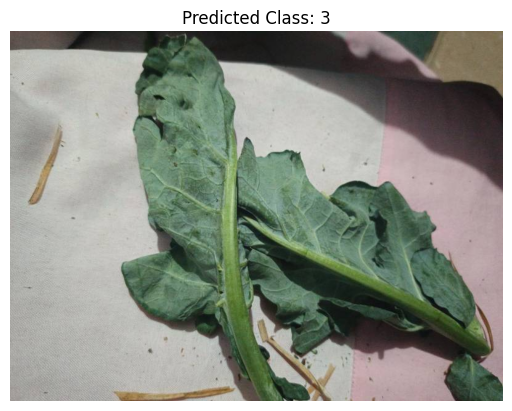

In [42]:
# Ruta de la imagen a probar
# image_path = ''  # Cambia esto a la ruta de tu imagen
# image_path = ''
# image_path = ''
image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train/Hojas-Brocoli/IMG_20250812_222510374_BURST0018.jpg'
# image_path = ''
# image_path = ''

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

#**4: Exportación del Modelo (TorchScript y ONNX)**

Una vez entrenado el modelo, lo exportamos a los formatos TorchScript y ONNX.

In [43]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 112.0 MB/s eta 0:00:00


In [44]:
import torch

# Exportar el modelo a TorchScript y ONNX
# TorchScript: torch.jit.trace permite exportar el modelo, manteniendo su
# estructura y lógica, lo cual es útil para implementaciones en producción.

scripted_model = torch.jit.script(model)
scripted_model.save('model_scripted.pt')

# ONNX: Proporciona interoperabilidad, permitiendo que el modelo se utilice en diferentes frameworks.
# Install onnx if you haven't already
!pip install onnx
import onnx # Import the onnx module

dummy_input = torch.randn(1, 3, 50, 50, device=device)
torch.onnx.export(model, dummy_input, 'model.onnx', verbose=True)

/tmp/ipython-input-3033166868.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, 'model.onnx', verbose=True)


In [46]:
# Exportar a TorchScript
example_input = torch.randn(1, 3, 50, 50).to(device) # Ejemplo de entrada, mover al dispositivo
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("mlp_model_script.pt")

# Exportar a ONNX
torch.onnx.export(model, example_input, "mlp_model.onnx", export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

/usr/local/lib/python3.12/dist-packages/torch/jit/_trace.py:1310: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 5 / 5 (100.0%)
Greatest absolute difference: 1.2487577348947525 at index (0, 2) (up to 1e-05 allowed)
Greatest relative difference: 12.863746688044587 at index (0, 3) (up to 1e-05 allowed)
  _check_trace(
/tmp/ipython-input-2385912081.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutori

**Interpretación de la Matriz de Confusión

La matriz de confusión muestra un resumen del rendimiento del modelo en el conjunto de prueba. Cada fila representa las clases reales (True Label) y cada columna representa las clases predichas (Predicted Label).

    Los valores en la diagonal principal indican el número de predicciones correctas para cada clase.
    Los valores fuera de la diagonal principal indican los errores de clasificación, es decir, cuándo el modelo predijo una clase pero la etiqueta real era otra.

Al analizar la matriz, puedes identificar qué clases el modelo está clasificando correctamente con mayor frecuencia y qué clases son más difíciles de distinguir, lo que te puede dar ideas para mejorar el modelo o el conjunto de datos.

En esta matriz:

    La clase "Bolsas-Soda" y "Cable-De-Red" tienen un alto número de predicciones correctas en la diagonal (800 y 800 respectivamente), lo que indica que el modelo las clasifica muy bien.
    La clase "Monedas" también tiene un alto número de predicciones correctas (798).
    La clase "Anillo-De-Lata" tiene 608 predicciones correctas, pero hay un número significativo de errores donde se predijo como "Hojas-Brocoli" (76).
    La clase "Hojas-Brocoli" tiene 663 predicciones correctas, pero también se confunde con "Anillo-De-Lata" (663).

Esto sugiere que el modelo puede tener algunas dificultades para distinguir entre "Anillo-De-Lata" y "Hojas-Brocoli".**

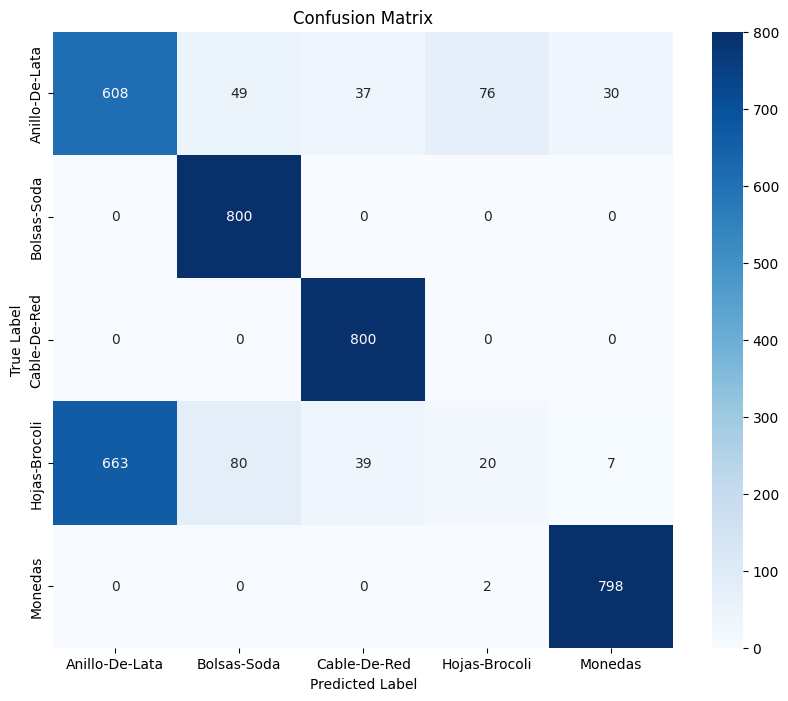

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is on the correct device and in evaluation mode
model.to(device)
model.eval()

all_labels = []
all_predictions = []

# Perform predictions on the test set
with torch.no_grad():
    for inputs, labels in dataloader['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Get class names
class_names = train_data.classes

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()